In [1]:
import urllib.request
import zipfile
import re

In [2]:
import pandas as pd

## URLs and file names at opendata.dwd.de

In [3]:
paths_and_patterns = {
    'daily_recent': {
        'url': 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/',
        'fn_pattern': r"tageswerte_KL_[\d]{5}_akt.zip",
        'fn_metadata': 'KL_Tageswerte_Beschreibung_Stationen.txt',
    },
    'daily_historical': {
        'url': 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/',
        'fn_pattern': r"tageswerte_KL_[\d]{5}_[\d]{8}_[\d]{8}_hist.zip",
        'fn_metadata': 'KL_Tageswerte_Beschreibung_Stationen.txt',
    }
}

## Function to get and parse metadata file

In [4]:
def get_daily_station_metadata(historical_or_recent='daily_recent'):
    url = (
        paths_and_patterns[historical_or_recent]['url'] 
        + paths_and_patterns[historical_or_recent]['fn_metadata']
    )
    df_header = pd.read_csv(
        url,
        nrows=1,
        encoding='ISO-8859-1',
        sep=' ',
    )
    
    df = pd.read_fwf( 
        url,
        encoding='ISO-8859-1',
        skiprows=1,
        # note that the width might not all be perfect, but the result looks good
        widths=[5, 9, 9, 15, 12, 10, 41, 40, 10],
    )
    df.columns = df_header.columns
    df = df.set_index('Stations_id')
    df.index = df.index.astype('str').str.zfill(5)
    return df

df_metadata = get_daily_station_metadata('daily_recent')
df_metadata.tail()

,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,Abgabe
Stations_id,,,,,,,,
19856,20240801,20250309,625,47.6134,12.9819,Schönau am Königssee,Bayern,Frei
19911,19631101,19860930,215,50.9625,10.0663,Gerstungen/Thüringen,Thüringen,Frei
19985,19810101,20031231,455,48.8457,8.9073,Weissach/Strudelbach,Baden-Württemberg,Frei
19989,19360101,20120630,147,50.0681,8.2603,Wiesbaden (Südost),Hessen,Frei
20007,18820101,19151231,332,50.8422,12.8770,Chemnitz-Altendorf,Sachsen,Frei


In [5]:
station_id = df_metadata[df_metadata.Stationsname.str.contains('Garmisch')].index[0]
station_id

'01550'

In [6]:
station_name = df_metadata.loc[station_id].Stationsname
station_name

'Garmisch-Partenkirchen'

## Functions to get filenames of raw data files at URL from opendata.dwd.de

In [7]:
def get_zip_file_names_from_url(historical_or_recent='daily_recent'):
    url = paths_and_patterns[historical_or_recent]['url']
    fn_pattern = paths_and_patterns[historical_or_recent]['fn_pattern']
    with urllib.request.urlopen(url) as response:
        html_content = response.read().decode()    
    
    fn_list = re.findall(fn_pattern, html_content)
    return sorted(set(fn_list))

def get_zip_file_name_for_station_id(station_id, fn_list):
    fn_list_subset = [fn for fn in fn_list if f'_{station_id}_' in fn]
    if len(fn_list_subset) == 0:
        raise FileNotFoundError(f'No file name found for station_id {station_id}')
    if len(fn_list_subset) > 1:
        raise ValueError(f'Found more than one file for station_id {station_id}')
    return fn_list_subset[0]
    

fn_list = get_zip_file_names_from_url('daily_historical')
fn_list[:5]

get_zip_file_name_for_station_id(station_id='01550', fn_list=fn_list)

'tageswerte_KL_01550_19360101_20231231_hist.zip'

## Function to download and parser all data for a specific station ID

In [8]:
def download_and_parse_daily_data_zip_file(url_for_file, historical_or_recent='daily_historical'):
    temp_file, _ = urllib.request.urlretrieve(url=url_for_file)
    
    
    with zipfile.ZipFile(temp_file, 'r') as zip_ref:
        txt_files = [
            f for f in zip_ref.namelist() if re.match(r"produkt_klima_tag_\d{8}_\d{8}_\d{5}.txt", f)
        ]
        if len(txt_files) == 0:
            print("Data file not found in the zip file.")
        elif len(txt_files) > 1:
            print("There should only be one matching data files in the zip file.")
        else:
            with zip_ref.open(txt_files[0], 'r') as csv_file:
                # Read the CSV data using the csv module
                df_data = pd.read_csv(csv_file, sep=';', na_values=-999, index_col=1, parse_dates=True)
    return df_data


def get_daily_data_for_station_id(station_id, historical_or_recent='both'):
    if historical_or_recent=='both':
        df_data_historical = get_daily_data_for_station_id(
            station_id=station_id, 
            historical_or_recent='daily_historical',
        )
        df_data_recent = get_daily_data_for_station_id(
            station_id=station_id,
            historical_or_recent='daily_recent',
        )
        df_data = pd.concat([df_data_historical, df_data_recent])
        df_data = df_data[~df_data.index.duplicated()]
        return df_data
    else:
        fn_list = get_zip_file_names_from_url(historical_or_recent)
        fn = get_zip_file_name_for_station_id(station_id=station_id, fn_list=fn_list)
        url_for_file = paths_and_patterns[historical_or_recent]['url'] + fn
        df_data = download_and_parse_daily_data_zip_file(
            url_for_file=url_for_file, 
            historical_or_recent=historical_or_recent,
        )
        return df_data
        

station_id = '01550' # Garmisch-Partenkirchen
# station_id = '05941' # Reit im 
# station_id = '03730' # Oberstdorf
# station_id = '03307' # Mittenwald Buckelwiesen
# station_id = '04261' # Rosenheim
# station_id = '02290' # Hohenpeißenberg

df = get_daily_data_for_station_id(station_id=station_id)

## Look at daily snow depth data

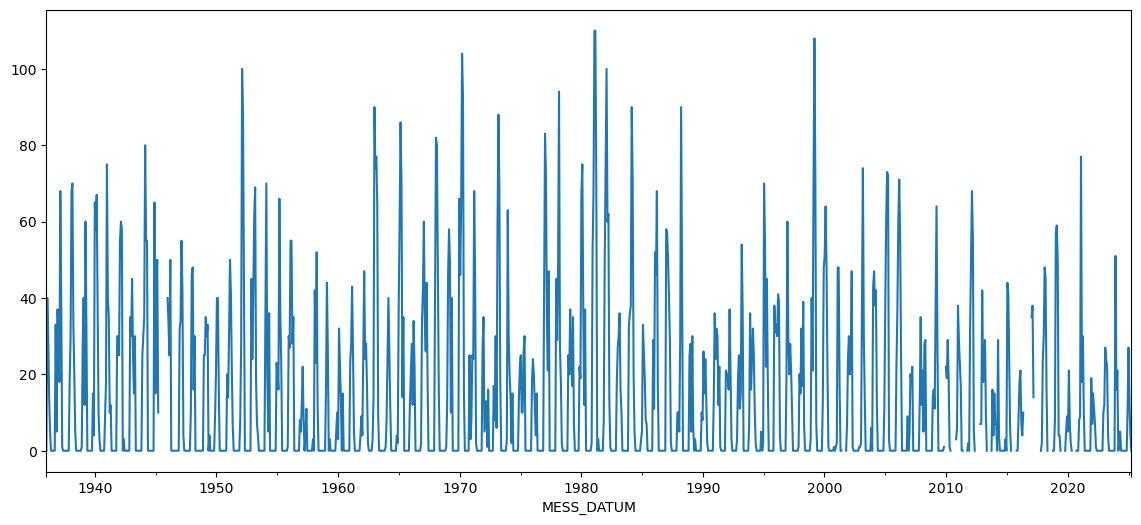

In [9]:
df.SHK_TAG.resample('4W').max().plot(figsize=(14, 6));

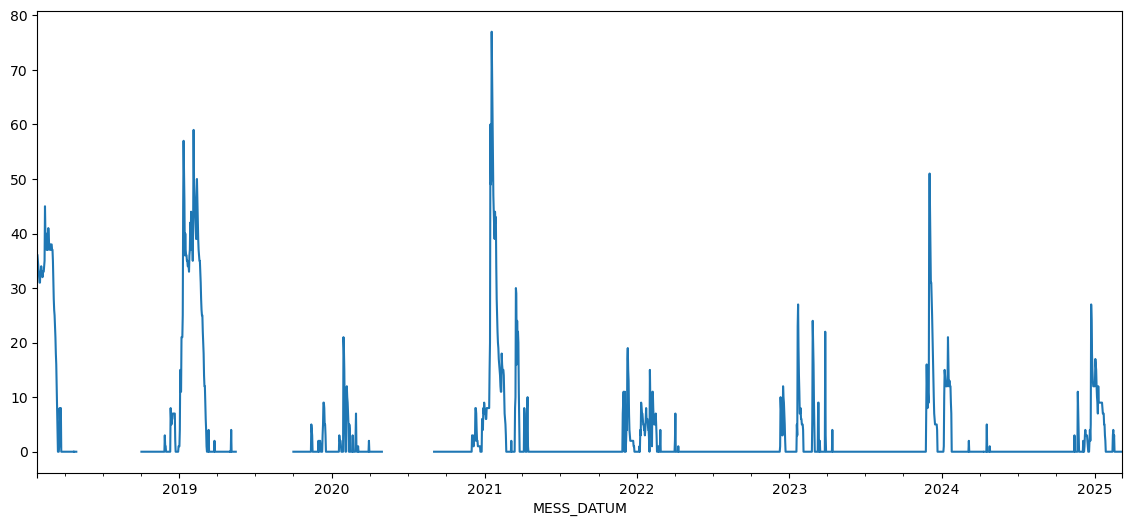

In [10]:
df.SHK_TAG[-2600:].plot(figsize=(14, 6));

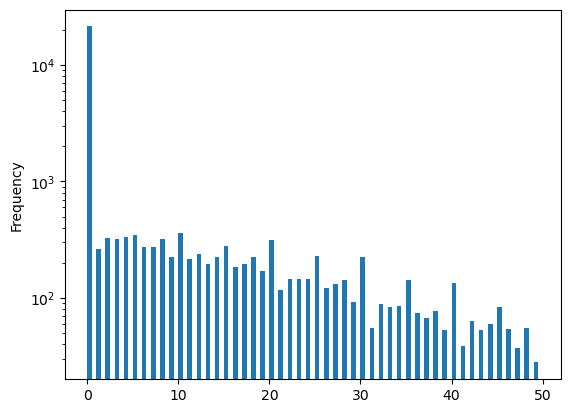

In [11]:
import numpy as np
df.SHK_TAG.plot.hist(bins=np.arange(0, 50, 0.5))
import matplotlib.pyplot as plt
plt.yscale('log')

## There are some interesting patterns in the distributiong of daily values for different decades

In the earlier years, when measurements were done manually, it seems that the manual observers tended to report snow depths values which are multiples of 5 or 10.

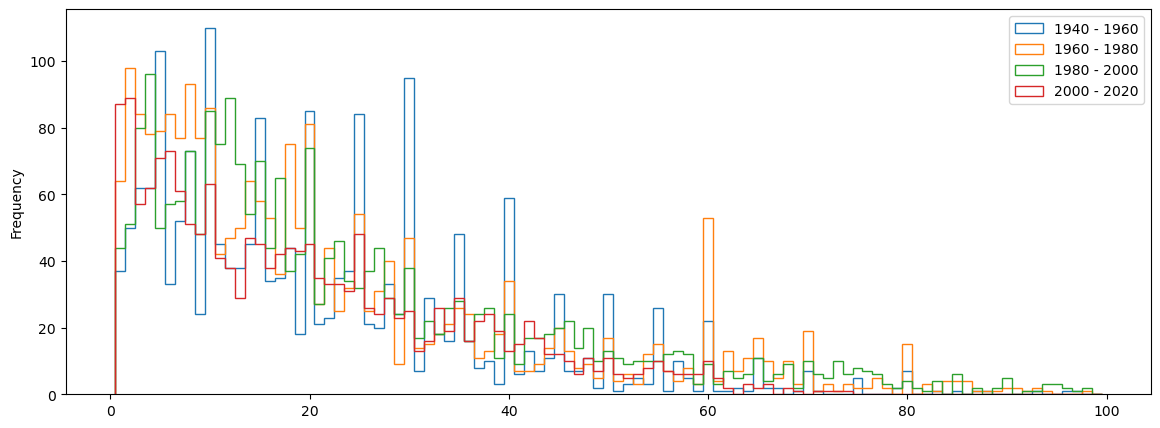

In [12]:
date_range = pd.date_range('1940', '2020', freq='20YS')
for i in range(len(date_range)-1):
    start = date_range[i]
    end = date_range[i+1]
    df.SHK_TAG[start:end].plot.hist(
        bins=np.arange(0.5, 100, 1), 
        histtype=u'step',
        #alpha=0.5,
        figsize=(14, 5),
        label=f'{start.year} - {end.year}',
    )
plt.legend();


## Define and crop to winter season

Values are shifted by 5 months first and then grouped by year so that we have one year value for one winter season, which includes Nov, Dec, Jan, Feb, Mar, Apr to also get earlt and late snowfall. This could of course be changed to the core winter months.

In [13]:
df['month'] = df.index.month

df['winter_season'] = df.shift(5, freq='ME').index.year 
df = df[df.month.isin([11, 12, 1, 2, 3, 4])]

df = df[df.index.year > 1920]

In [14]:
g_list = []
for winter_season, g in df.groupby(df.winter_season):
    g['non_nan_values_per_season'] = (~g.SHK_TAG.isna()).sum()
    #g['month_day'] = range(len(g.index))
    date_range = pd.date_range(f'{winter_season-1}-11-01 00:00:00+00:00', f'{winter_season}-03-31 00:00:00+00:00')
    #g['day_of_winter_season'] = np.where(date_range.isin(g.index))
    g_list.append(g)

df_new = pd.concat(g_list)

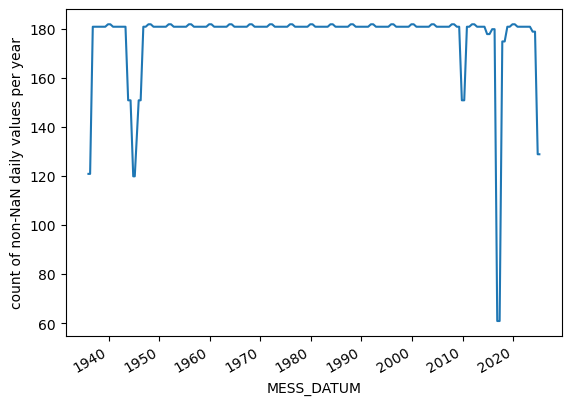

In [15]:
df_new.non_nan_values_per_season.plot();
plt.ylabel('count of non-NaN daily values per year');

## Plot number of days with snow depth >= 1 cm per year

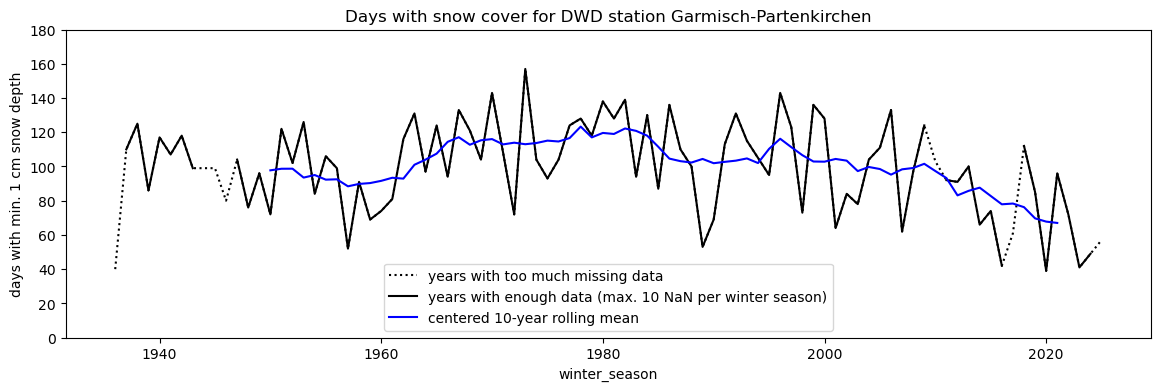

In [16]:
snow_min = 1

days_with_snow_cover = (df_new.SHK_TAG >= snow_min).groupby(df_new.winter_season).sum()
winter_season_with_enough_data = df_new.non_nan_values_per_season.groupby(df_new.winter_season).max() > 170

days_with_snow_cover.plot(figsize=(14, 8), c='k', linestyle=':', label='years with too much missing data')

days_with_snow_cover[~winter_season_with_enough_data] = pd.NA

days_with_snow_cover.plot(c='k', figsize=(14, 4), label='years with enough data (max. 10 NaN per winter season)')
#days_with_snow_cover.rolling(5, center=True, min_periods=4).mean().rolling(3, center=True, min_periods=3).mean().plot(c='b', alpha=1)
#days_with_snow_cover.rolling(5, center=True, min_periods=4).mean().plot(c='b', label='centered 5-year rolling mean')
#days_with_snow_cover.rolling(7, center=True, min_periods=6).mean().plot(c='b', label='centered 7-year rolling mean')
days_with_snow_cover.rolling(10, center=True, min_periods=8).mean().plot(c='b', label='centered 10-year rolling mean')
#days_with_snow_cover.rolling(10, center=True, min_periods=9).mean().plot(c='r', alpha=0.3)

plt.legend()
plt.ylabel(f'days with min. {snow_min} cm snow depth')
plt.ylim(0, 180)
plt.title(f'Days with snow cover for DWD station {station_name}');

## Plot number of days with snow depth >= 10 cm per year

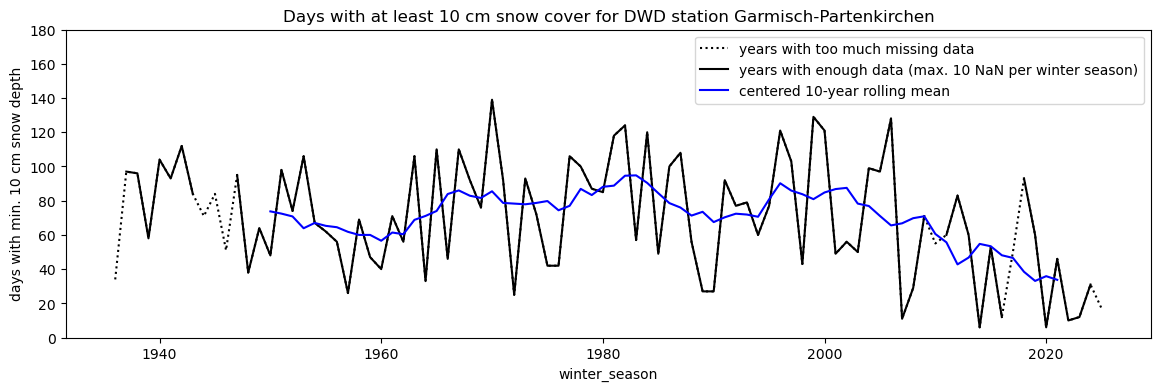

In [17]:
snow_min = 10

days_with_snow_cover = (df_new.SHK_TAG >= snow_min).groupby(df_new.winter_season).sum()
winter_season_with_enough_data = df_new.non_nan_values_per_season.groupby(df_new.winter_season).max() > 170

days_with_snow_cover.plot(figsize=(14, 8), c='k', linestyle=':', label='years with too much missing data')

days_with_snow_cover[~winter_season_with_enough_data] = pd.NA

days_with_snow_cover.plot(c='k', figsize=(14, 4), label='years with enough data (max. 10 NaN per winter season)')
days_with_snow_cover.rolling(10, center=True, min_periods=8).mean().plot(c='b', label='centered 10-year rolling mean')

plt.legend()
plt.ylabel(f'days with min. {snow_min} cm snow depth')
plt.ylim(0, 180)
plt.title(f'Days with at least {snow_min} cm snow cover for DWD station {station_name}');

## Plot daily snowcover for all years as heatmap

To do that we pivot the DataFrame first.

In [18]:
df_shifted = df.shift(5 * 30, freq='D')
df_shifted['day_of_year'] = df_shifted.index.day_of_year
df_shifted['year'] = df_shifted.index.year

df_pivoted = df_shifted.pivot(index='year', columns='day_of_year', values='SHK_TAG')
#df_pivoted

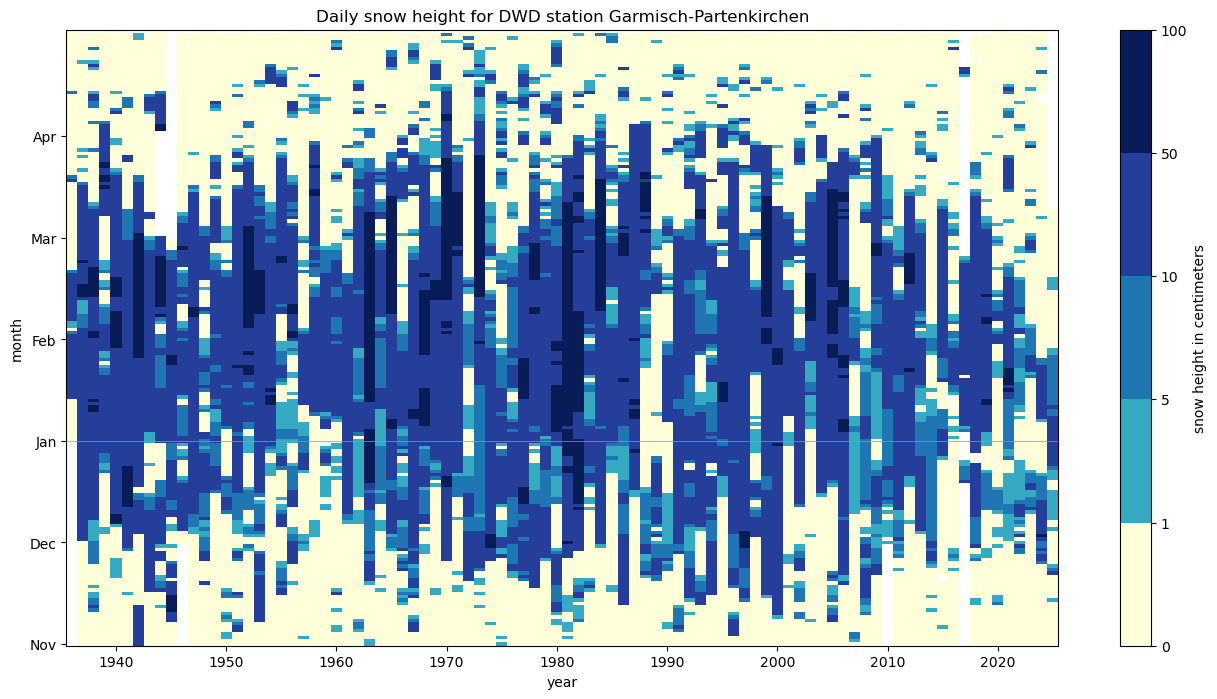

In [19]:
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap

cmap = plt.get_cmap('YlGnBu', 256)
colors = [cmap(0),] + [cmap(i) for i in range(100, 256)]
cmap = LinearSegmentedColormap.from_list('cut_YlGnBu', colors)

levels=[0, 1, 5, 10, 50, 100]
norm = BoundaryNorm(levels, ncolors=cmap.N)



fig, ax = plt.subplots(figsize=(16, 8))
pc = plt.pcolormesh(
    df_pivoted.index, 
    df_pivoted.columns - 5 * 30, 
    df_pivoted.T, 
    norm=norm,
    cmap=cmap,
);
plt.yticks([-60, -30, 0, 30, 60, 90], labels=['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']);
plt.axhline(y=0, c='C1', linewidth=0.5)
plt.colorbar(pc, label='snow height in centimeters')
plt.xlabel('year')
plt.ylabel('month')
plt.title(f'Daily snow height for DWD station {station_name}');